<a href="https://colab.research.google.com/github/vkt1414/Cloud-Resources-Workflows/blob/main/Notebooks/Totalsegmentator/inferenceTotalSegmentatorNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This Notebook does the second step in the split workflow on Terra

The NIFTI files generated from first step are provided as input for Inference.


Please cite:

Jakob Wasserthal, Manfred Meyer, Hanns-Christian Breit, Joshy Cyriac, Shan Yang, & Martin Segeroth. (2022). TotalSegmentator: robust segmentation of 104 anatomical structures in CT images. https://doi.org/10.48550/arXiv.2208.05868

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nat Methods 18, 203–211 (2021). https://doi.org/10.1038/s41592-020-01008-z

###Installing Packages

In [ ]:
# %%capture
# #Installing lz4 for compression/decompression
# #xvfb required for previewing Totalsegmentator png images
# !apt-get install lz4 xvfb

In [ ]:
# %%capture
# #Installing Totalsegmentator for Inference
# #pyradiomics required for extracting radiomics features 
# #nvidia-ml-py3 for capturing gpu utilization
# !pip install TotalSegmentator pyradiomics nvidia-ml-py3

In [ ]:
import glob

#Get the file path of the 
lz4_file_path = glob.glob('downloadDicomAndConvertNiftiFiles.tar.lz4')[0]
#lz4_file_path = '/content/drive/MyDrive/idc_vamsi/downloadDicomAndConvertNiftiFiles.tar.lz4'

!lz4 -d {lz4_file_path} -c | tar xvf -

#!lz4 -d /content/drive/MyDrive/idc_vamsi/downloadDicomAndConvertNiftiFiles.tar.lz4 -c | tar xvf -

dcm2niix/
dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405/
dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405/1.3.6.1.4.1.14519.5.2.1.7009.9004.21767310514022109288482935440_2_OPA_GE_LS16_STANDARD_290_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz
dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.188290278428073689858811092699/
dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.188290278428073689858811092699/1.3.6.1.4.1.14519.5.2.1.7009.9004.18829027842807368985881109269_2_OPA_GE_LS16_STANDARD_320_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz
dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.201570275370759657429616658271/
dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.201570275370759657429616658271/1.3.6.1.4.1.14519.5.2.1.7009.9004.20157027537075965742961665827_2_OPA_GE_LS16_STANDARD_390_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz
dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.223093097797078712983021476504/
dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.22309309779707871298

###Parameters for papermill

In [ ]:
converterType='dcm2niix'

###Defining Functions

In [ ]:
import os
import sys
import shutil
from pathlib import Path
import time

In [ ]:
#create directory for TotalSegmentator Output files
try:
  shutil.rmtree('Inference')
except OSError:
  pass
os.mkdir('Inference')

In [ ]:
curr_dir   = Path().absolute()

print(time.asctime(time.localtime()))
print("\nCurrent directory :{}".format( curr_dir))
print("Python version    :", sys.version.split('\n')[0])

Fri Mar 24 14:59:47 2023

Current directory :/content
Python version    : 3.9.16 (main, Dec  7 2022, 01:11:51) 


In [ ]:
from concurrent.futures import ThreadPoolExecutor
from time import sleep
from datetime import datetime
import psutil
import time
import pandas as pd
import matplotlib.pyplot as plt
import nvidia_smi

class MemoryMonitor:
    def __init__(self):
        self.keep_measuring = True

    def measure_usage(self):
        cpu_usage = []
        ram_usage_mb=[]
        gpu_usage_mb=[]
        disk_usage_all=[]
        time_stamps = []
        start_time = time.time()
        while self.keep_measuring:
            cpu = psutil.cpu_percent()
            ram = psutil.virtual_memory()
            disk_used= psutil.disk_usage('/').used/1024/1024/1024
            disk_total= psutil.disk_usage('/').total/1024/1024/1024
            ram_total_mb = psutil.virtual_memory().total / 1024 / 1024
            ram_mb = (ram.total - ram.available) / 1024 / 1024

            nvidia_smi.nvmlInit()
            handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
            info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
            gpu_type = nvidia_smi.nvmlDeviceGetName(handle)
            gpu_total_mb = info.total/1024/1024
            gpu_mb = info.used/1024/1024
            nvidia_smi.nvmlShutdown()

            cpu_usage.append(cpu)
            ram_usage_mb.append(ram_mb)
            disk_usage_all.append(disk_used)
            gpu_usage_mb.append(gpu_mb)
            time_stamps.append(time.time()- start_time)
            sleep(1)

        return cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, gpu_usage_mb, gpu_total_mb, gpu_type, disk_usage_all, disk_total

In [ ]:
def inferenceTotalSegmentator(series_id):
      try:
        shutil.rmtree(f'Inference/{series_id}')
      except OSError:
        pass
      os.mkdir(f'Inference/{series_id}')

      print("Processing series: "+series_id)  

      log = pd.DataFrame({'SeriesInstanceUID': [series_id]}) 
      series_id_folder_path= os.path.join(curr_dir, 'dcm2niix', series_id)
      # Get the list of files in series_id_path
      nifti_files = os.listdir(series_id_folder_path)
      # Get the first (and only) file in the list
      nifti_filename = nifti_files[0]
      # Get the full path of the file
      nifti_filename_path = os.path.join(series_id_folder_path, nifti_filename)
      print(nifti_filename_path)

      start_time = time.time()
      !TotalSegmentator -i {nifti_filename_path} -o {curr_dir}/Inference/{series_id}/{series_id}.nii --ml --fast --preview  --radiomics 
      total_segmentator_time = time.time() - start_time

      start_time = time.time()     
      !lz4 {curr_dir}/Inference/{series_id}/{series_id}.nii  {curr_dir}/Inference/{series_id}/{series_id}.nii.lz4
      archiving_time = time.time() - start_time

      log['total_segmentator_time']=total_segmentator_time
      log['archiving_time'] = archiving_time

      !rm -r {curr_dir}/Inference/{series_id}/{series_id}.nii 
      !rm -r {curr_dir}/dcm2niix/{series_id}
      global runtime_stats
      runtime_stats = pd.concat([runtime_stats, log], ignore_index=True, axis=0)

###Total Segmentator

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405/1.3.6.1.4.1.14519.5.2.1.7009.9004.21767310514022109288482935440_2_OPA_GE_LS16_STANDARD_290_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Download finished. Extracting...
  downloaded in 11.33s
Resampling...
  Resampled in 6.08s
Predicting...
  Predicted in 16.42s
Generating preview...
  Generated in 4.37s
Resampling...
Saving segmentations...
  Saved in 2.08s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.10s
Compressed 109587904 bytes into 2606623 bytes ==> 2.38%


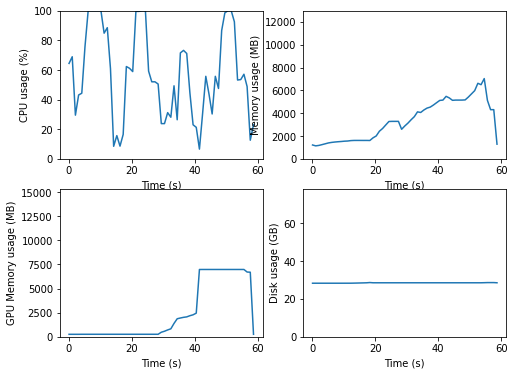

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.463009574831800529812210003081
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.463009574831800529812210003081/1.3.6.1.4.1.14519.5.2.1.7009.9004.46300957483180052981221000308_2_OPA_GE_LS16_STANDARD_340_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 6.87s
Predicting...
  Predicted in 8.94s
Generating preview...
  Generated in 4.28s
Resampling...
Saving segmentations...
  Saved in 3.65s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.09s
Compressed 115879360 bytes into 2283447 bytes ==> 1.97%


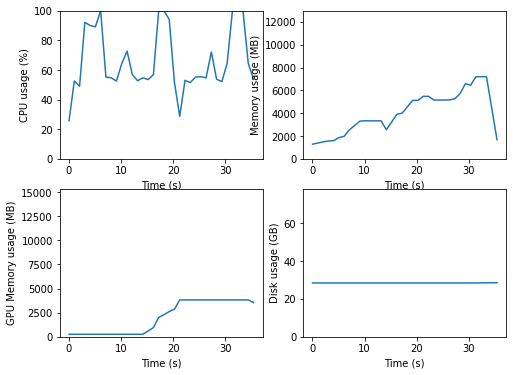

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.223093097797078712983021476504
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.223093097797078712983021476504/1.3.6.1.4.1.14519.5.2.1.7009.9004.22309309779707871298302147650_2_OPA_GE_LS16_STANDARD_430_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 6.99s
Predicting...
  Predicted in 8.38s
Generating preview...
  Generated in 7.46s
Resampling...
Saving segmentations...
  Saved in 1.55s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.09s
Compressed 113257920 bytes into 2575734 bytes ==> 2.27%


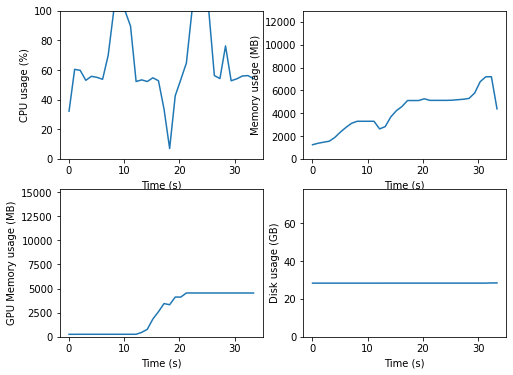

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.201570275370759657429616658271
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.201570275370759657429616658271/1.3.6.1.4.1.14519.5.2.1.7009.9004.20157027537075965742961665827_2_OPA_GE_LS16_STANDARD_390_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 5.79s
Predicting...
  Predicted in 8.94s
Generating preview...
  Generated in 4.68s
Resampling...
Saving segmentations...
  Saved in 2.53s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.12s
Compressed 105917888 bytes into 2246313 bytes ==> 2.12%


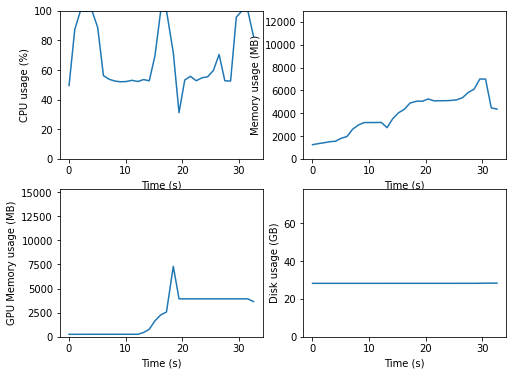

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.207023621705859785782756947262
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.207023621705859785782756947262/1.3.6.1.4.1.14519.5.2.1.7009.9004.20702362170585978578275694726_2_OPA_GE_LSPR16_STANDARD_360_1.2_120_80_58.2_1.4_20010102000000_3.nii.gz

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 5.06s
Predicting...
  Predicted in 7.75s
Generating preview...
  Generated in 2.62s
Resampling...
Saving segmentations...
  Saved in 2.26s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.12s
Compressed 85208512 bytes into 1913779 bytes ==> 2.25%


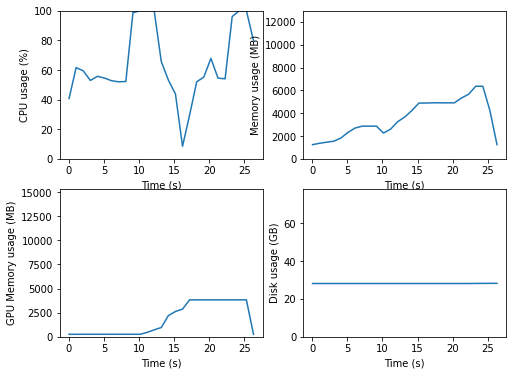

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.188290278428073689858811092699
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.188290278428073689858811092699/1.3.6.1.4.1.14519.5.2.1.7009.9004.18829027842807368985881109269_2_OPA_GE_LS16_STANDARD_320_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 7.12s
Predicting...
  Predicted in 8.04s
Generating preview...
  Generated in 4.76s
Resampling...
Saving segmentations...
  Saved in 2.30s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.09s
Compressed 115092928 bytes into 2303881 bytes ==> 2.00%


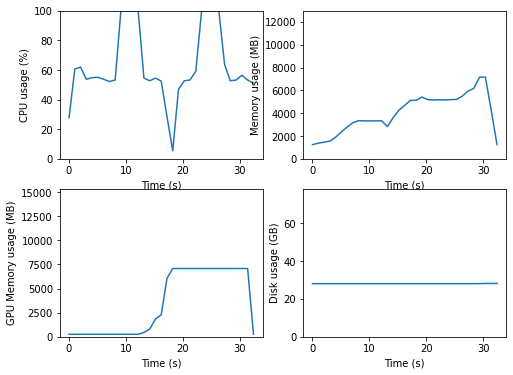

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.232142785210222351126080087655
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.232142785210222351126080087655/1.3.6.1.4.1.14519.5.2.1.7009.9004.23214278521022235112608008765_2_OPA_GE_LS16_STANDARD_290_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 6.52s
Predicting...
  Predicted in 8.45s
Generating preview...
  Generated in 3.63s
Resampling...
Saving segmentations...
  Saved in 2.13s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.09s
Compressed 119287232 bytes into 3243979 bytes ==> 2.72%


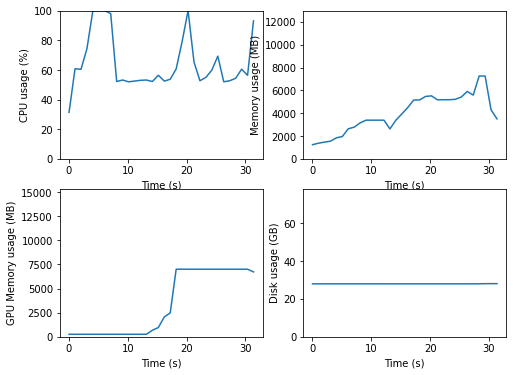

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.210325478147363329031787355411
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.210325478147363329031787355411/1.3.6.1.4.1.14519.5.2.1.7009.9004.21032547814736332903178735541_2_OPA_GE_LS16_STANDARD_382_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 6.45s
Predicting...
  Predicted in 9.19s
Generating preview...
  Generated in 5.79s
Resampling...
Saving segmentations...
  Saved in 1.93s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.09s
Compressed 113782208 bytes into 2647527 bytes ==> 2.33%


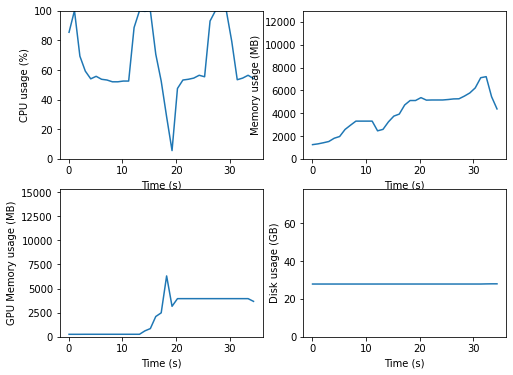

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.278216906052022558158291630814
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.278216906052022558158291630814/1.3.6.1.4.1.14519.5.2.1.7009.9004.27821690605202255815829163081_2_OPA_GE_LS16_STANDARD_340_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 6.40s
Predicting...
  Predicted in 8.48s
Generating preview...
  Generated in 4.63s
Resampling...
Saving segmentations...
  Saved in 1.44s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.09s
Compressed 111947200 bytes into 2211095 bytes ==> 1.98%


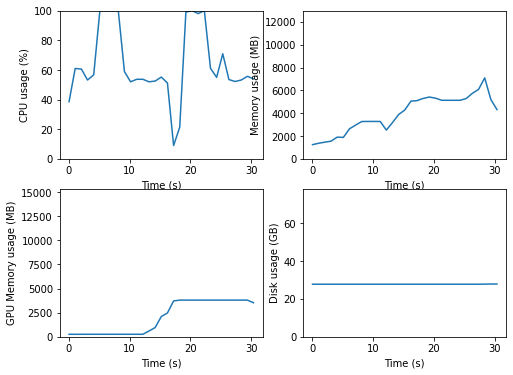

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.183901372798721911743379690105
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.183901372798721911743379690105/1.3.6.1.4.1.14519.5.2.1.7009.9004.18390137279872191174337969010_2_OPA_GE_LS16_STANDARD_360_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 5.71s
Predicting...
  Predicted in 8.84s
Generating preview...
  Generated in 4.14s
Resampling...
Saving segmentations...
  Saved in 1.95s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.11s
Compressed 108539328 bytes into 2220388 bytes ==> 2.05%


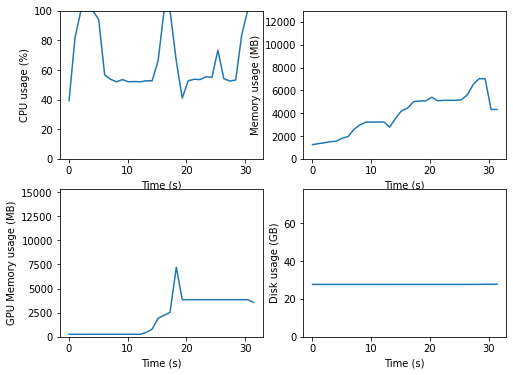

In [ ]:
runtime_stats = pd.DataFrame(columns=['SeriesInstanceUID','total_segmentator_time',
                                      'archiving_time', 'cpu_usage','ram_usage_mb', 'ram_total_mb', 
                                      'gpu_usage_mb', 'gpu_total_mb', 'gpu_type', 'disk_usage_all', 'disk_total'
                                      ])
if __name__ == "__main__":
    for series_id in os.listdir(f'{curr_dir}/dcm2niix'):
        with ThreadPoolExecutor() as executor:
            monitor = MemoryMonitor()
            mem_thread = executor.submit(monitor.measure_usage)
            try:
                proc_thread = executor.submit(inferenceTotalSegmentator, series_id)
                proc_thread.result()
            finally:
                monitor.keep_measuring = False
                cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, gpu_usage_mb, gpu_total_mb, gpu_type, disk_usage_all, disk_total= mem_thread.result()
                
                cpu_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[cpu_idx, runtime_stats.columns.get_loc('cpu_usage')] = [[cpu_usage]]

                ram_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_usage_mb_idx, runtime_stats.columns.get_loc('ram_usage_mb')] = [[ram_usage_mb]]
                
                ram_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_total_mb_idx, runtime_stats.columns.get_loc('ram_total_mb')] = [[ram_total_mb]]

                gpu_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[gpu_total_mb_idx, runtime_stats.columns.get_loc('gpu_total_mb')] = [[gpu_total_mb]]

                gpu_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[gpu_usage_mb_idx, runtime_stats.columns.get_loc('gpu_usage_mb')] = [[gpu_usage_mb]]

                disk_usage_gb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[disk_usage_gb_idx, runtime_stats.columns.get_loc('disk_usage_all')] = [[disk_usage_all]]

                runtime_stats['gpu_type']=gpu_type
                runtime_stats['disk_total']=disk_total    

                fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(8, 6)) 

                ax1.plot(time_stamps, cpu_usage)
                ax1.set_ylim(0, 100)
                ax1.set_xlabel('Time (s)')
                ax1.set_ylabel('CPU usage (%)')

                ax2.plot(time_stamps, ram_usage_mb)
                ax2.set_ylim(0, ram_total_mb)
                ax2.set_xlabel('Time (s)')
                ax2.set_ylabel('Memory usage (MB)')

                ax3.plot(time_stamps, gpu_usage_mb)
                ax3.set_ylim(0, gpu_total_mb)
                ax3.set_xlabel('Time (s)')
                ax3.set_ylabel('GPU Memory usage (MB)')

                ax4.plot(time_stamps, disk_usage_all)
                ax4.set_ylim(0, disk_total)
                ax4.set_xlabel('Time (s)')
                ax4.set_ylabel('Disk usage (GB)')
                plt.show()

###Compressing Output Files

In [ ]:
start_time = time.time()
try:
  os.remove('inferenceNiftiFiles.tar.lz4')
except OSError:
  pass
!tar cvf - Inference | lz4 > inferenceNiftiFiles.tar.lz4
archiving_time = time.time() - start_time


Inference/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405/preview_total.png
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405/1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405.nii.lz4
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405/statistics_radiomics.json
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.463009574831800529812210003081/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.463009574831800529812210003081/preview_total.png
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.463009574831800529812210003081/statistics_radiomics.json
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.463009574831800529812210003081/1.3.6.1.4.1.14519.5.2.1.7009.9004.463009574831800529812210003081.nii.lz4
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.223093097797078712983021476504/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.223093097797078712983021476504/pr

###Utilization Metrics

In [ ]:
runtime_stats.to_csv('runtime.csv')
runtime_stats['archiving_time']=archiving_time
try:
  os.remove('inferenceUsageMetrics.lz4')
except OSError:
  pass
!lz4 {curr_dir}/runtime.csv inferenceUsageMetrics.lz4
runtime_stats

Compressed 19706 bytes into 7863 bytes ==> 39.90%


,SeriesInstanceUID,total_segmentator_time,archiving_time,cpu_usage,ram_usage_mb,ram_total_mb,gpu_usage_mb,gpu_total_mb,gpu_type,disk_usage_all,disk_total
0,1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140...,58.436017,0.120187,"[[[64.4, 68.9, 29.5, 43.1, 44.3, 75.6, 100.0, ...","[[[1218.21875, 1141.43359375, 1181.29296875, 1...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 258.3125, 261...",[15360.0],b'Tesla T4',"[[[28.259788513183594, 28.259803771972656, 28....",78.189842
1,1.3.6.1.4.1.14519.5.2.1.7009.9004.463009574831...,35.577557,0.120187,"[[[25.8, 52.5, 49.0, 92.1, 90.0, 89.1, 100.0, ...","[[[1289.90234375, 1388.23828125, 1492.55859375...",[12985.546875],"[[[258.3125, 258.3125, 261.1875, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[28.398914337158203, 28.39891815185547, 28.3...",78.189842
2,1.3.6.1.4.1.14519.5.2.1.7009.9004.223093097797...,33.980646,0.120187,"[[[32.2, 60.4, 59.7, 53.0, 55.7, 55.0, 53.7, 6...","[[[1241.55078125, 1369.62890625, 1465.56640625...",[12985.546875],"[[[258.3125, 258.3125, 261.1875, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[28.302879333496094, 28.30288314819336, 28.3...",78.189842
3,1.3.6.1.4.1.14519.5.2.1.7009.9004.201570275370...,32.877381,0.120187,"[[[49.5, 87.3, 100.0, 99.5, 100.0, 88.6, 56.2,...","[[[1244.578125, 1334.640625, 1413.09375, 1502....",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[28.199298858642578, 28.199302673339844, 28....",78.189842
4,1.3.6.1.4.1.14519.5.2.1.7009.9004.207023621705...,26.255257,0.120187,"[[[40.7, 61.6, 59.4, 52.9, 55.7, 54.5, 52.7, 5...","[[[1245.36328125, 1368.63671875, 1465.5, 1551....",[12985.546875],"[[[258.3125, 258.3125, 261.1875, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[28.106464385986328, 28.106468200683594, 28....",78.189842
5,1.3.6.1.4.1.14519.5.2.1.7009.9004.188290278428...,32.365771,0.120187,"[[[27.7, 60.6, 61.9, 53.7, 54.8, 55.0, 53.7, 5...","[[[1248.80078125, 1375.83203125, 1469.8203125,...",[12985.546875],"[[[258.3125, 258.3125, 261.1875, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[28.024349212646484, 28.02435302734375, 28.0...",78.189842
6,1.3.6.1.4.1.14519.5.2.1.7009.9004.232142785210...,31.668035,0.120187,"[[[31.4, 60.8, 60.4, 74.3, 100.0, 100.0, 100.0...","[[[1246.07421875, 1374.171875, 1470.0, 1550.45...",[12985.546875],"[[[258.3125, 258.3125, 261.1875, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[27.92992401123047, 27.929927825927734, 27.9...",78.189842
7,1.3.6.1.4.1.14519.5.2.1.7009.9004.210325478147...,34.699471,0.120187,"[[[85.4, 100.0, 69.3, 59.2, 54.0, 55.7, 53.7, ...","[[[1248.9140625, 1316.1328125, 1413.28515625, ...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[27.830825805664062, 27.830829620361328, 27....",78.189842
8,1.3.6.1.4.1.14519.5.2.1.7009.9004.278216906052...,30.653855,0.120187,"[[[38.6, 61.0, 60.6, 53.2, 56.7, 100.0, 100.0,...","[[[1247.46875, 1369.96875, 1466.140625, 1551.6...",[12985.546875],"[[[258.3125, 258.3125, 261.1875, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[27.72928237915039, 27.729286193847656, 27.7...",78.189842
9,1.3.6.1.4.1.14519.5.2.1.7009.9004.183901372798...,31.849694,0.120187,"[[[39.2, 81.5, 100.0, 100.0, 100.0, 94.0, 56.7...","[[[1246.703125, 1339.18359375, 1413.5703125, 1...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[27.635807037353516, 27.63581085205078, 27.6...",78.189842
